In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.feature import hog, local_binary_pattern
from skimage import exposure
from tensorflow.keras.datasets import fashion_mnist
from sklearn.preprocessing import normalize, StandardScaler
import os
import cv2
import numpy as np
from mahotas.features import zernike_moments
import time
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import logging
import joblib

In [2]:
# EXTRACTOR SETTING
HOG_PARAM = {'pixels_per_cell': (4, 4), 'cells_per_block': (1, 1)}
LPB_PARAM = {'radius': 1, 'n_points': 8, 'method': 'uniform'}
SIFT_PARAM = {'thresh': 5}   # Lower threshold to detect more keypoints
# SURF_PARAM = {'hessianThreshold': 100}  # Reduce threshold to detect weak features
# ORB_PARAM = {'nfeatures': 100}  # Fewer features due to small image size
GLCM_PARAM = {
    'distances': [1, 2],  
    'angles': [0, np.pi/4, np.pi/2, 3*np.pi/4],  # orientations（0°, 45°, 90°, 135°）
    'properties': ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
}

# MODEL SETTING
CLASSIFIERS = {
        "SVM": SVC(kernel='linear'),
        "Naive Bayes": GaussianNB(),
        "Random Forest": RandomForestClassifier(),
        "KNN": KNeighborsClassifier(),
        # "LightGBM": lgb.LGBMClassifier()  # Uncomment if using LightGBM
    }
PARAM_GRIDS = {
        "SVM": {},
        "Naive Bayes": {}, #"var_smoothing": [1e-9, 1e-8, 1e-7]
        "Random Forest": {'n_estimators': [100, 200], 'max_depth': [10, 20, None]},
        "KNN": {'n_neighbors': [3, 5, 7]},
        # "LightGBM": {'num_leaves': [31, 50], 'learning_rate': [0.01, 0.05], 'n_estimators': [100]}  
    }

In [3]:
#Preparing the dataset
train_path = r"C:\Users\81903\Desktop\coursework\thesis\6. repo\IMGRECO\week3-replicate\report\datasets\fmnist\equalized_train_images_labels-f1"
test_path = r"C:\Users\81903\Desktop\coursework\thesis\6. repo\IMGRECO\week3-replicate\report\datasets\fmnist\equalized_test_images_labels-f"
models = {}

image_path_train = []
for i in range(10):
    dir = os.path.join(train_path, str(i))
    for file in os.listdir(dir):
        image_path_train.append(os.path.join(dir, file))


image_path_test = []
for i in range(10):
    dir = os.path.join(test_path, str(i))
    for file in os.listdir(dir):
        image_path_test.append(os.path.join(dir, file))

# Create a log file for recording training results
log_filename = "training_log_handcrafted_FMNIST.txt"
logging.basicConfig(filename=log_filename, level=logging.INFO, format="%(asctime)s - %(message)s")

# Log the start of the training process
logging.info("***************This is the logging book for F-MNIST datasets******************")

In [4]:
# the features extrated in this cells are all of fixed shapes 

def get_hog_features(img):
    """
    Extract HOG features from images.
    """
    pixels_per_cell= HOG_PARAM.get('pixels_per_cell')
    cells_per_block= HOG_PARAM.get('cells_per_block')

    # Ensure the image is in grayscale
    img_resized = img.astype(np.float32)
    # Extract HOG features
    features, _ = hog(
        img_resized,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        visualize=True
    )
    return features


def get_lpb_features(img ):
    """
    Extract LBP features from images.
    """
    radius = LPB_PARAM.get('radius')
    n_points = LPB_PARAM.get('n_points')
    method = LPB_PARAM.get('method')

    # Ensure the image is in grayscale
    img_resized = img.astype(np.float32)
    # Extract LBP features
    lbp = local_binary_pattern(img_resized, P=n_points, R=radius, method=method)
    # Flatten LBP into a histogram
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, n_points + 3), density=True)
    return lbp_hist

def get_glcm_features(img):
    """
    Extract GLCM features from images.
    """
    distances = GLCM_PARAM.get('distances')
    angles = GLCM_PARAM.get('angles')
    properties = GLCM_PARAM.get('properties')

    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = img.astype(np.uint8)

    glcm = graycomatrix(img, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    feature_vector = []
    for prop in properties:
        feature_vector.extend(graycoprops(glcm, prop).flatten())

    return feature_vector

# 45 dimension
def get_zernike_features(img):
    """
    Extract Zernike moments as features.
    """
    radius = 14  # Half of 28x28 image size
    features = zernike_moments(img, radius, degree=8)
    return features

def get_fix_feature(image_path, method):
    labels = []
    vec = []
    count = 0
    for file in image_path:
        img = cv2.imread(file, 0)
        img = img / 255.0
        if method == 'hog':
            img_des = get_hog_features(img)
        elif method == 'lbp':
            img_des = get_lpb_features(img)
        elif method == 'glcm':
            img_des = get_glcm_features(img)
        elif method == 'zm':
            img_des = get_zernike_features(img)
        else:
            raise ValueError("Unsupported feature extraction method.")

        if img_des is not None:
#             img_vec = bag_of_features(img_des, centres, k)
            vec.append(img_des)
            # Get the folder name and convert it to a number
            folder_name = os.path.basename(os.path.dirname(file))
            labels.append(int(folder_name))
        else:
            count = count + 1
            print(f'No feature extractedf ${count}')
    vec = np.vstack(vec)
    scaler = StandardScaler()
    feature = scaler.fit_transform(vec)

    return feature, labels

In [5]:
# SIFT features are not of fixed length, we use k-means approach

def get_SIFT_feature(image_path):
    """
    Extracts image features using SIFT and performs K-Means clustering.

    """

    # Set default parameters for feature extraction
    sift_thresh = SIFT_PARAM.get('thresh', 0)

    def CalcFeatures(img):
        
        extractor = cv2.SIFT_create(sift_thresh)
        kp, des = extractor.detectAndCompute(img, None)
        return des

    # Extract features from all images
    features = []
    for file in image_path:
        img = cv2.imread(file, 0)
        # img = img / 255.0
        img_des = CalcFeatures(img)
        if img_des is not None:
            features.append(img_des)

    # Stack all feature descriptors into a single array
    features = np.vstack(features)

    """
    Perform K-Means clustering on the extracted features.
    The cluster centers obtained will be used for feature encoding.
    """

    k = 150  # Number of clusters
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1)
    flags = cv2.KMEANS_RANDOM_CENTERS
    compactness, labels, centres = cv2.kmeans(features, k, None, criteria, 10, flags)

    """
    Convert feature descriptors into a Bag of Words representation.
    Each feature is assigned to the nearest cluster center.
    """

    def bag_of_features(features, centres, k=500):
        vec = np.zeros((1, k))
        for i in range(features.shape[0]):
            feat = features[i]
            diff = np.tile(feat, (k, 1)) - centres
            dist = np.sqrt((diff ** 2).sum(axis=1))
            idx = dist.argmin()  # Get the nearest cluster index
            vec[0][idx] += 1
        return vec

    # Create feature vectors for each image
    labels = []
    vec = []
    for file in image_path:
        img = cv2.imread(file, 0)
        # img = img / 255.0
        img_des = CalcFeatures(img)
        if img_des is not None:
            img_vec = bag_of_features(img_des, centres, k)
        else:
            img_vec = np.zeros((1, k))  # Zero-padding for images with no detected keypoints
        vec.append(img_vec)

        # Extract label from the subdirectory name
        folder_name = os.path.basename(os.path.dirname(file))
        labels.append(int(folder_name))
    # Stack feature vectors into a matrix
    vec = np.vstack(vec)
    scaler = StandardScaler()
    feature = scaler.fit_transform(vec)

    return feature, labels


In [6]:
def feature_combiner(feature1, feature2, method="stand"):
    """
    Combine two features for a set of images.
    """
    combined_features = np.hstack((feature1, feature2))
    feature = normalize(combined_features, norm='l2')
    return feature

In [7]:

# def compute_flops(model, x_train):
#     """
#     Estimate Floating-Point Operations per Second (FLOPs) for models that support it.
#     Only works for models that can be converted to PyTorch.
#     """
#     try:
#         x_sample = torch.randn(1, x_train.shape[1])  # Simulate input tensor
#         macs, params = ptflops.get_model_complexity_info(model, (x_train.shape[1],), as_strings=True)
#         print(f"FLOPs: {macs}, Parameters: {params}")
#     except Exception as e:
#         print(f"Could not compute FLOPs: {e}")

def classifier_grid_search(x_train, y_train, x_test, y_test, classifiers=CLASSIFIERS, param_grids=PARAM_GRIDS):
    
    # Store the best models
    best_models = {}

    for clf_name, clf in classifiers.items():
        print(f"Training {clf_name}...")
        logging.info(f"Training {clf_name}...")

        # Set up the grid search with 5-fold cross-validation
        grid_search = GridSearchCV(estimator=clf, param_grid=param_grids[clf_name], cv=5, scoring='accuracy', n_jobs=-1)

        # Record the training time
        start_time = time.time()
        grid_search.fit(x_train, y_train)
        training_time = time.time() - start_time
        print(f"{clf_name} - Training time: {training_time:.4f} seconds")
        logging.info(f"{clf_name} - Training time: {training_time:.4f} seconds")

        # Get the best model from grid search
        best_model = grid_search.best_estimator_
        best_models[clf_name] = best_model

        # Record the inference time
        start_inference_time = time.time()
        y_pred = best_model.predict(x_test)
        inference_time = time.time() - start_inference_time
        avg_inference_time = inference_time / len(x_test)  

        print(f"{clf_name} - Inference time: {inference_time:.4f} seconds")
        print(f"{clf_name} - Average inference time per sample: {avg_inference_time:.6f} seconds")
        logging.info(f"{clf_name} - Inference time: {inference_time:.4f} seconds")
        logging.info(f"{clf_name} - Average inference time per sample: {avg_inference_time:.6f} seconds")

        # Evaluate the results
        accuracy = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        clf_report = classification_report(y_test, y_pred)

        print(f"{clf_name} - Accuracy: {accuracy * 100:.2f}%")
        print(f"{clf_name} - Confusion Matrix:\n{cm}")
        print(f"{clf_name} - Classification Report:\n{clf_report}")
        logging.info(f"{clf_name} - Accuracy: {accuracy * 100:.2f}%")
        logging.info(f"{clf_name} - Confusion Matrix:\n{cm}")
        logging.info(f"{clf_name} - Classification Report:\n{clf_report}")

        # Plot confusion matrix
        plt.figure(figsize=(6, 5))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(f'{clf_name} - Confusion Matrix')
        plt.colorbar()
        tick_marks = np.arange(len(np.unique(y_test)))
        plt.xticks(tick_marks, tick_marks)
        plt.yticks(tick_marks, tick_marks)
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.tight_layout()
        plt.show()

    # Perform t-SNE Visualization
    try:
        tsne_visualization(x_train, y_train)
    except Exception as e:
        print(f"Error in tsne_visualization: {str(e)}")
        logging.info(f"Error in tsne_visualization: {str(e)}")

    return best_models



def tsne_visualization(x_train, y_train, sample_size=1000):
    """
    Perform t-SNE visualization on a sample of data.
    """
    # 确保 x_train, y_train 是 NumPy 数组
    x_train = np.array(x_train)
    y_train = np.array(y_train)

    # 采样数据
    if x_train.shape[0] > sample_size:
        idx = np.random.choice(x_train.shape[0], sample_size, replace=False)
        x_train, y_train = x_train[idx], y_train[idx]

    print("Performing t-SNE...")
    tsne = TSNE(n_components=2, perplexity=30, method='barnes_hut', init='pca', random_state=42)
    x_embedded = tsne.fit_transform(x_train)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(x_embedded[:, 0], x_embedded[:, 1], c=y_train, cmap='jet', alpha=0.5)
    plt.colorbar(scatter, label="Classes")
    plt.title("t-SNE Visualization of Feature Space")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()


## HOG


In [8]:
# Measure time for HOG feature extraction
start = time.time()
x_train_hog, y_train_hog = get_fix_feature(image_path_train, 'hog')
x_test_hog, y_test_hog = get_fix_feature(image_path_test, 'hog')
end = time.time()
print(f"HOG feature extraction time: {end - start:.2f} seconds")
logging.info(f"HOG feature extraction time: {end - start:.2f} seconds")

HOG feature extraction time: 1001.98 seconds


Training SVM...
SVM - Training time: 4552.8974 seconds
SVM - Inference time: 84.8936 seconds
SVM - Average inference time per sample: 0.008489 seconds
SVM - Accuracy: 84.87%
SVM - Confusion Matrix:
[[819   5  21  26   7   0 112   0  10   0]
 [  8 948   4  24   8   0   7   0   1   0]
 [ 23   0 771  14  96   0  92   0   4   0]
 [ 30  28  10 864  26   0  40   0   2   0]
 [  2   1  91  46 765   0  92   0   3   0]
 [  0   0   0   0   0 935   1  45   3  16]
 [156   4  96  44  97   0 591   0  12   0]
 [  0   0   0   0   0  30   0 942   0  28]
 [ 17   2   6   3  18   6  20   4 924   0]
 [  1   0   0   0   0  19   1  50   1 928]]
SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1000
           1       0.96      0.95      0.95      1000
           2       0.77      0.77      0.77      1000
           3       0.85      0.86      0.86      1000
           4       0.75      0.77      0.76      1000
           5     

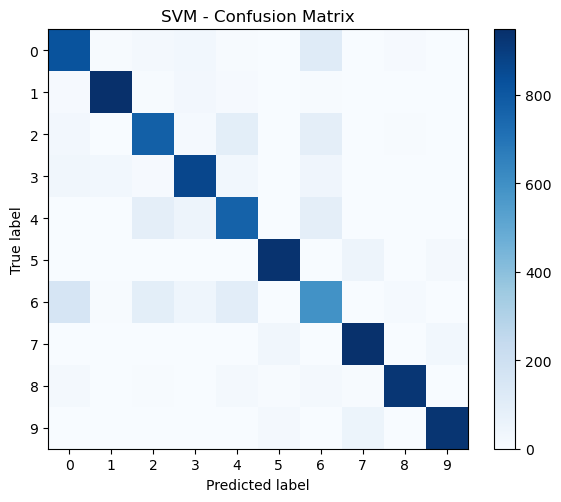

Training Naive Bayes...
Naive Bayes - Training time: 2.5979 seconds
Naive Bayes - Inference time: 0.6616 seconds
Naive Bayes - Average inference time per sample: 0.000066 seconds
Naive Bayes - Accuracy: 23.67%
Naive Bayes - Confusion Matrix:
[[ 907    0    0    0    0    0   71    0   22    0]
 [ 854    0    0    0    0    0  110    0   36    0]
 [ 166    0    0    0    0    0  814    0   20    0]
 [ 715    0    0    0    0    0  242    0   43    0]
 [ 203    0    0    0    0    0  786    0   11    0]
 [   0    0    0    0    0    0   48    0  952    0]
 [ 360    0    0    0    0    0  604    0   36    0]
 [   0    0    0    0    0    0    0    0 1000    0]
 [  47    0    0    0    0    0   97    0  856    0]
 [   1    0    0    0    0    0   33    0  966    0]]
Naive Bayes - Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.91      0.43      1000
           1       0.00      0.00      0.00      1000
           2       0.00    

D:\software\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\software\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\software\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


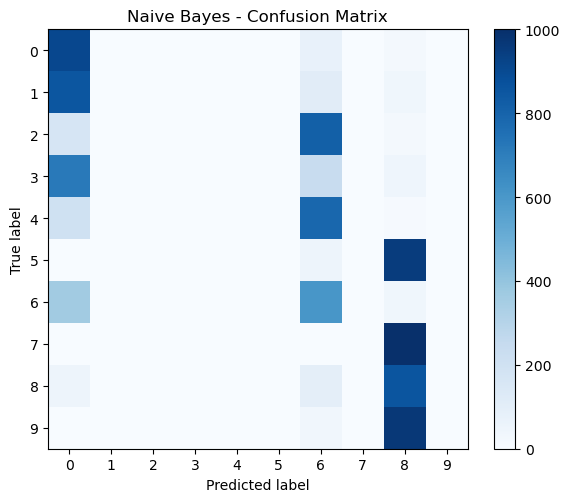

Training Random Forest...
Random Forest - Training time: 2139.4708 seconds
Random Forest - Inference time: 1.2180 seconds
Random Forest - Average inference time per sample: 0.000122 seconds
Random Forest - Accuracy: 84.74%
Random Forest - Confusion Matrix:
[[824   3  22  48   6   0  82   0  15   0]
 [  0 932   6  31  12   0  15   0   4   0]
 [  9   0 806  12  79   0  86   0   8   0]
 [ 16  12   4 869  33   0  60   0   6   0]
 [  0   0 132  49 712   0 103   0   4   0]
 [  0   0   0   0   0 911   1  51   9  28]
 [198   1  93  40  82   0 565   0  21   0]
 [  0   0   0   0   0  17   0 940   6  37]
 [  0   1   9   5   9   4  12   2 958   0]
 [  0   0   1   0   0   5   0  37   0 957]]
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.81      1000
           1       0.98      0.93      0.96      1000
           2       0.75      0.81      0.78      1000
           3       0.82      0.87      0.85      1000
  

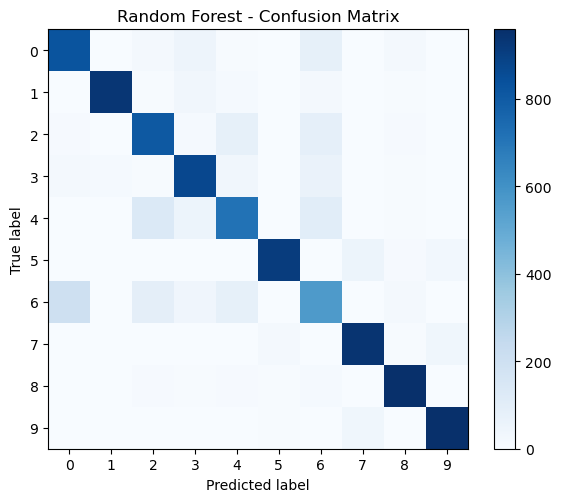

Training KNN...
KNN - Training time: 96.3016 seconds
KNN - Inference time: 8.2859 seconds
KNN - Average inference time per sample: 0.000829 seconds
KNN - Accuracy: 84.15%
KNN - Confusion Matrix:
[[846   8  19  37  11   0  70   0   9   0]
 [  4 969   3  13   8   0   1   0   2   0]
 [ 31   1 761  15 124   0  65   0   3   0]
 [ 17  38  16 869  41   0  19   0   0   0]
 [  1   4 122  37 766   0  70   0   0   0]
 [  0   0   0   1   0 873   0  83   1  42]
 [192   9 115  37 136   0 497   0  14   0]
 [  0   0   0   0   0   4   0 962   0  34]
 [ 14   2   7   2  24   6  12  12 918   3]
 [  0   0   0   0   0   1   0  44   1 954]]
KNN - Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.85      0.80      1000
           1       0.94      0.97      0.95      1000
           2       0.73      0.76      0.74      1000
           3       0.86      0.87      0.86      1000
           4       0.69      0.77      0.73      1000
           5       0

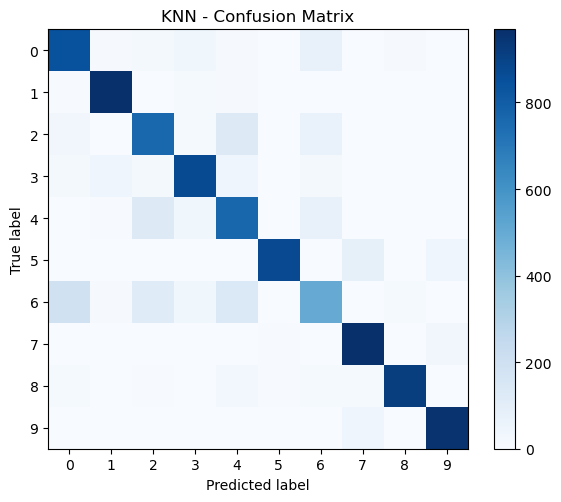

Performing t-SNE...


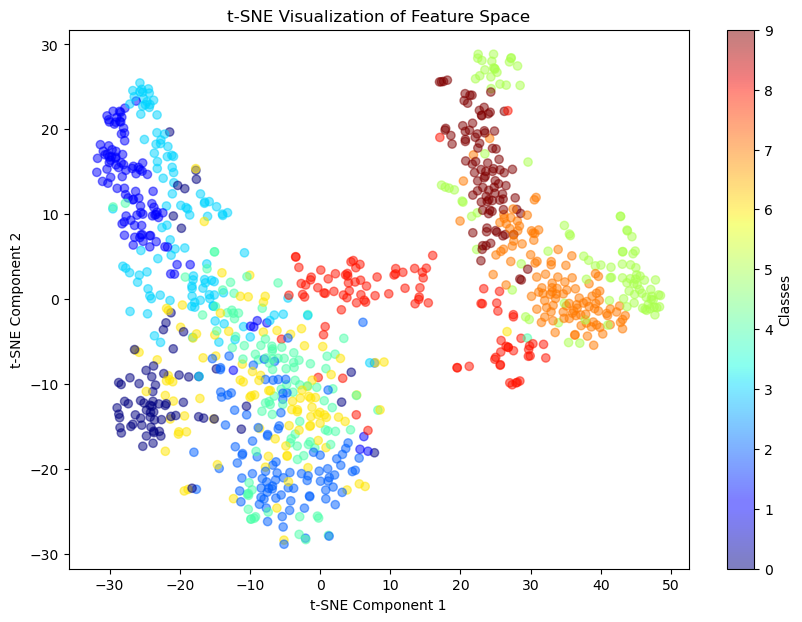

In [9]:
models_hog = classifier_grid_search(x_train_hog, y_train_hog, x_test_hog, y_test_hog)
models['models_hog'] = models_hog

## LBP


In [10]:
# Measure time for LBP feature extraction
start = time.time()
x_train_lbp, y_train_lbp = get_fix_feature(image_path_train, 'lbp')
x_test_lbp, y_test_lbp = get_fix_feature(image_path_test, 'lbp')
end = time.time()
print(f"LBP feature extraction time: {end - start:.2f} seconds")
logging.info(f"LBP feature extraction time: {end - start:.2f} seconds")

D:\software\anaconda\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
D:\software\anaconda\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


LBP feature extraction time: 78.49 seconds


Training SVM...
SVM - Training time: 601.5928 seconds
SVM - Inference time: 33.7181 seconds
SVM - Average inference time per sample: 0.003372 seconds
SVM - Accuracy: 47.67%
SVM - Confusion Matrix:
[[379   7  89  91 143   6  75   1 151  58]
 [ 10 801  16 113   8   5   5   5  23  14]
 [ 76   3 531  46  98   3 122   4  96  21]
 [ 63 157  61 389  44   6  26  11  93 150]
 [187   3 159  74 279   0 155   2  97  44]
 [  2   6  22   5   4 715   6 133  36  71]
 [147   5 291  55 160  14 189   2 101  36]
 [  4  15  21  22   2 186   2 634   8 106]
 [165  15  97  66  67  54  68   9 353 106]
 [ 82   1  22  69  29  78   2 112 108 497]]
SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.38      0.36      1000
           1       0.79      0.80      0.80      1000
           2       0.41      0.53      0.46      1000
           3       0.42      0.39      0.40      1000
           4       0.33      0.28      0.30      1000
           5      

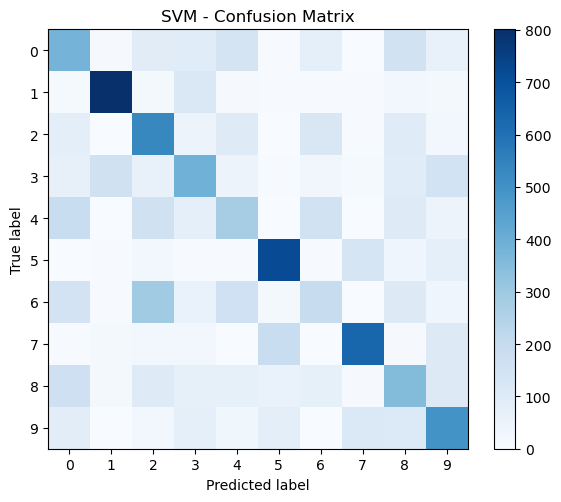

Training Naive Bayes...
Naive Bayes - Training time: 1.3328 seconds
Naive Bayes - Inference time: 0.0169 seconds
Naive Bayes - Average inference time per sample: 0.000002 seconds
Naive Bayes - Accuracy: 42.43%
Naive Bayes - Confusion Matrix:
[[201  16  75  57 309   9 103   1 151  78]
 [  8 799  11  72  13  21   9  30  10  27]
 [ 29   4 389  47 222   9 135   2  84  79]
 [ 36 228  60 242  98  26  44  23  61 182]
 [ 80   2 122  27 495   2 126   3  60  83]
 [  0  12  57  19   6 468  32 215  67 124]
 [ 89   9 240  43 264   7 242   1  70  35]
 [  2  50  16  12   9  78   3 699   2 129]
 [ 88  33  62 102 179  27  88  21 214 186]
 [ 66   9  23  42 142   5  10 141  68 494]]
Naive Bayes - Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.20      0.25      1000
           1       0.69      0.80      0.74      1000
           2       0.37      0.39      0.38      1000
           3       0.37      0.24      0.29      1000
           4       

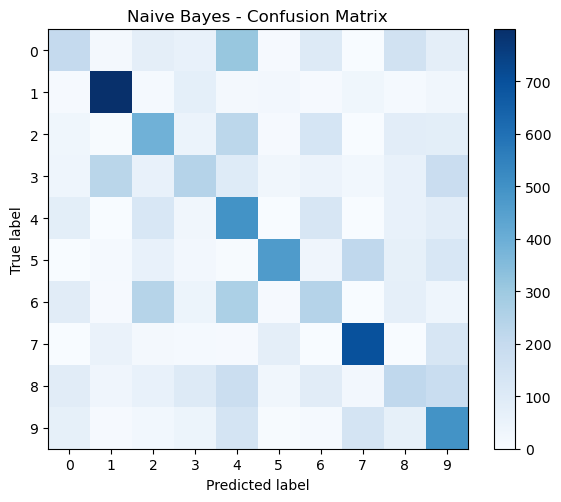

Training Random Forest...
Random Forest - Training time: 203.2149 seconds
Random Forest - Inference time: 0.9705 seconds
Random Forest - Average inference time per sample: 0.000097 seconds
Random Forest - Accuracy: 52.03%
Random Forest - Confusion Matrix:
[[367  10  98  71 157   3  96   0 117  81]
 [ 13 801  18 130   5   0   2   8  12  11]
 [ 59   2 477  66 116   6 162   4  83  25]
 [ 59 112  44 503  55   8  32  17  70 100]
 [153   1 143  67 349   0 141   2  92  52]
 [  6   4   8   9   1 726  10 155  27  54]
 [132   3 195  55 165   4 316   2  87  41]
 [  3  18  14  16   3  98   1 712   5 130]
 [137  15  91  64 111  42  71   9 328 132]
 [ 50   2   9  50  43  17   7 114  84 624]]
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.37      0.37      1000
           1       0.83      0.80      0.81      1000
           2       0.43      0.48      0.45      1000
           3       0.49      0.50      0.50      1000
   

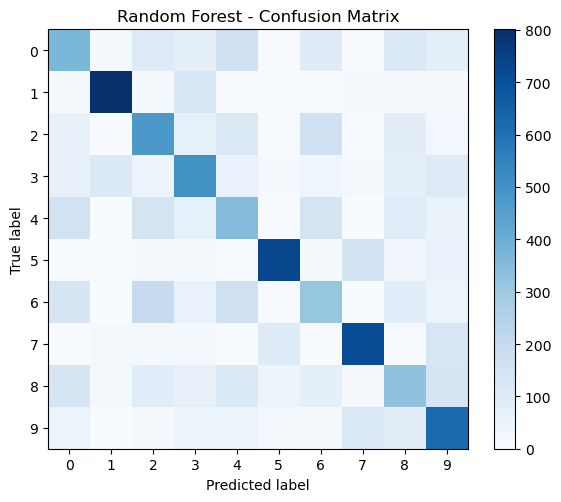

Training KNN...
KNN - Training time: 13.8194 seconds
KNN - Inference time: 3.3233 seconds
KNN - Average inference time per sample: 0.000332 seconds
KNN - Accuracy: 47.27%
KNN - Confusion Matrix:
[[376  14 128  80 142   8  98   1 105  48]
 [ 18 823  20  97  10   2   1  10  10   9]
 [102   6 474  59 127   8 132   8  56  28]
 [113 168  75 418  59   5  33  14  46  69]
 [219   3 173  67 299   1 120   0  79  39]
 [  8   4  22  19   5 704  11 138  34  55]
 [198   6 236  62 164   7 236   1  66  24]
 [  5  17  11  20   7 124   3 695   8 110]
 [193  30 119  65 144  39  58  21 231 100]
 [ 75   6  24  74  61  29  12 158  90 471]]
KNN - Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.38      0.33      1000
           1       0.76      0.82      0.79      1000
           2       0.37      0.47      0.42      1000
           3       0.43      0.42      0.43      1000
           4       0.29      0.30      0.30      1000
           5       0

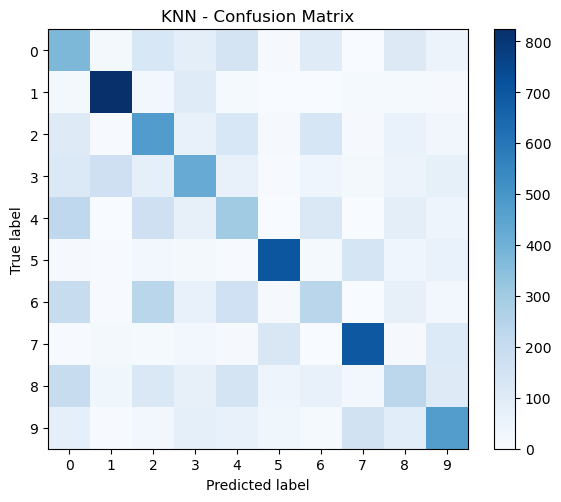

Performing t-SNE...


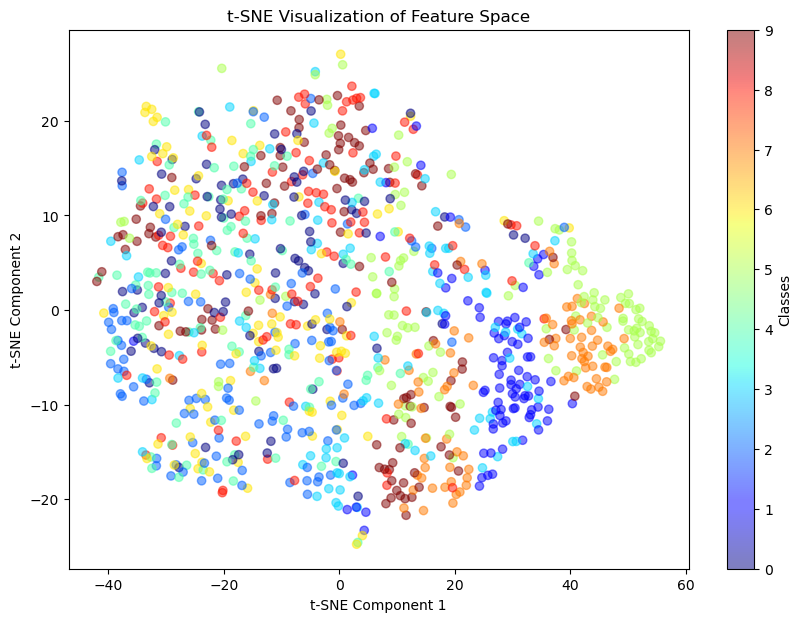

In [11]:
models_lbp = classifier_grid_search(x_train_lbp, y_train_lbp, x_test_lbp, y_test_lbp)
models['models_lbp'] = models_lbp

## GLCM


In [12]:
# Measure time for GLCM feature extraction
start = time.time()
x_train_glcm, y_train_glcm = get_fix_feature(image_path_train, 'glcm')
x_test_glcm, y_test_glcm = get_fix_feature(image_path_test, 'glcm')
end = time.time()
print(f"GLCM feature extraction time: {end - start:.2f} seconds")
logging.info(f"GLCM feature extraction time: {end - start:.2f} seconds")

GLCM feature extraction time: 6228.97 seconds


Training SVM...
SVM - Training time: 1720.5106 seconds
SVM - Inference time: 52.1418 seconds
SVM - Average inference time per sample: 0.005214 seconds
SVM - Accuracy: 28.78%
SVM - Confusion Matrix:
[[429 124  31  40 176  97  45  40   7  11]
 [ 76 674  21  60 125  25  12   2   2   3]
 [184 372  50  34 228  77  14  21   3  17]
 [264 312  22  69 218  67  23  14   4   7]
 [180 315  25  33 313  90  20  11   1  12]
 [ 15   5   5   2 120 466   4 254  24 105]
 [201 273  32  35 247 106  67  25   0  14]
 [  0   0   2   0  20 290   0 480  31 177]
 [150 107  16  27 110 148   3 216 100 123]
 [ 37  10   2   1  32 272   1 351  64 230]]
SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.43      0.34      1000
           1       0.31      0.67      0.42      1000
           2       0.24      0.05      0.08      1000
           3       0.23      0.07      0.11      1000
           4       0.20      0.31      0.24      1000
           5     

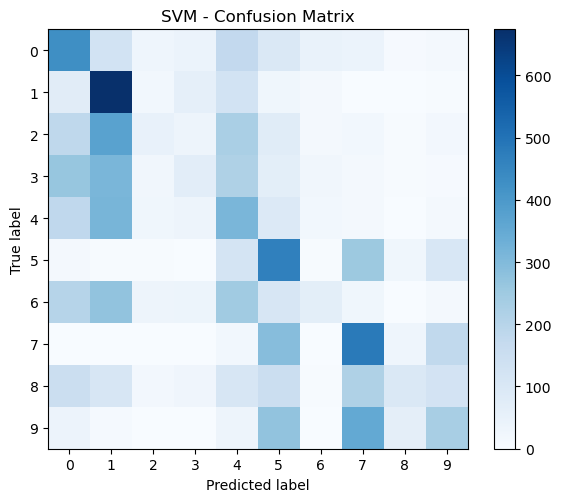

Training Naive Bayes...
Naive Bayes - Training time: 1.5627 seconds
Naive Bayes - Inference time: 0.0730 seconds
Naive Bayes - Average inference time per sample: 0.000007 seconds
Naive Bayes - Accuracy: 21.97%
Naive Bayes - Confusion Matrix:
[[ 27 291  52  34   2  26 144  36 222 166]
 [  6 797  23  15   2   9  71   1  37  39]
 [ 12 614  53  11   2  11  67  16  79 135]
 [  8 521  47  36   2  14  93  13 145 121]
 [ 10 583  48  16   0  16  96  22  73 136]
 [  1 114  17   6   0  39  60 229  22 512]
 [ 18 479  28  12   3  28 163  19  91 159]
 [  1  15  12   6   0  23  48 330  31 534]
 [  2 231  39  39   1  14  42 161 152 319]
 [  5  52  21  18   0   8  18 215  63 600]]
Naive Bayes - Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.03      0.05      1000
           1       0.22      0.80      0.34      1000
           2       0.16      0.05      0.08      1000
           3       0.19      0.04      0.06      1000
           4       

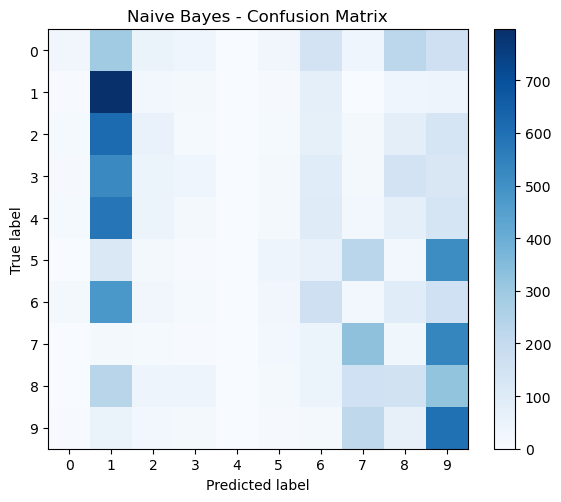

Training Random Forest...
Random Forest - Training time: 54.8324 seconds
Random Forest - Inference time: 0.3010 seconds
Random Forest - Average inference time per sample: 0.000030 seconds
Random Forest - Accuracy: 28.38%
Random Forest - Confusion Matrix:
[[348  87  43  36 140 104  81  75  57  29]
 [ 54 495 103  64 151  30  34   7  57   5]
 [143 241 135  37 211  84  30  46  52  21]
 [214 214  63  87 189  85  41  31  53  23]
 [126 177 101  35 247 130  54  53  58  19]
 [ 12   7   1   1  45 361   8 333  71 161]
 [138 162  88  41 214 131 122  41  39  24]
 [  4   3   1   0   6 145   2 498  80 261]
 [127  86  26  33  76 111   6 231 194 110]
 [ 32   7   5   5  21 153   4 310 112 351]]
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.35      0.32      1000
           1       0.33      0.49      0.40      1000
           2       0.24      0.14      0.17      1000
           3       0.26      0.09      0.13      1000
    

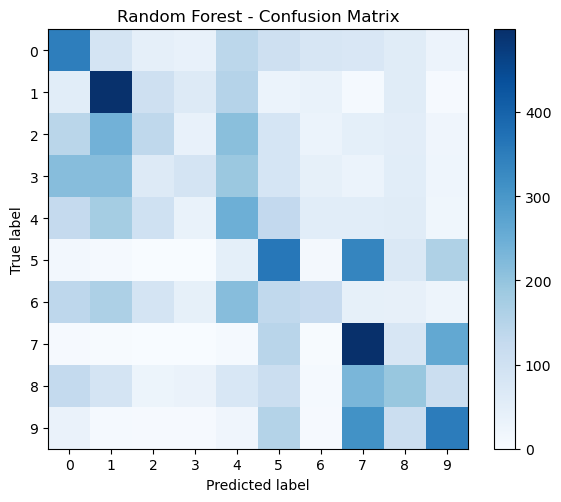

Training KNN...
KNN - Training time: 20.4509 seconds
KNN - Inference time: 1.5628 seconds
KNN - Average inference time per sample: 0.000156 seconds
KNN - Accuracy: 15.89%
KNN - Confusion Matrix:
[[794  61  49  16  19  33  17   8   2   1]
 [729 220  15  16   9   0   9   0   1   1]
 [802 119  37   4  10  12   6   9   1   0]
 [779 132  38  19  12  10   6   3   1   0]
 [798 111  15  14  24  22  12   2   1   1]
 [636   6   6  15  16 233   1  59   8  20]
 [761  94  26  18  23  23  36  11   4   4]
 [391   4   8  21  15 391   0 117  16  37]
 [533  41  25  22  12 192   1  91  67  16]
 [424   5   9  12   9 381   2  89  27  42]]
KNN - Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.79      0.21      1000
           1       0.28      0.22      0.25      1000
           2       0.16      0.04      0.06      1000
           3       0.12      0.02      0.03      1000
           4       0.16      0.02      0.04      1000
           5       0

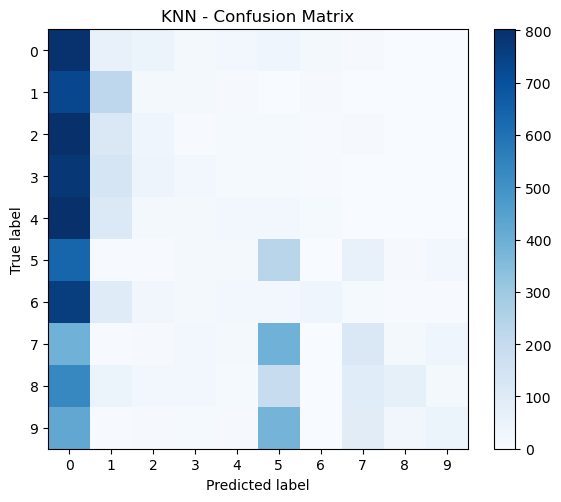

Performing t-SNE...


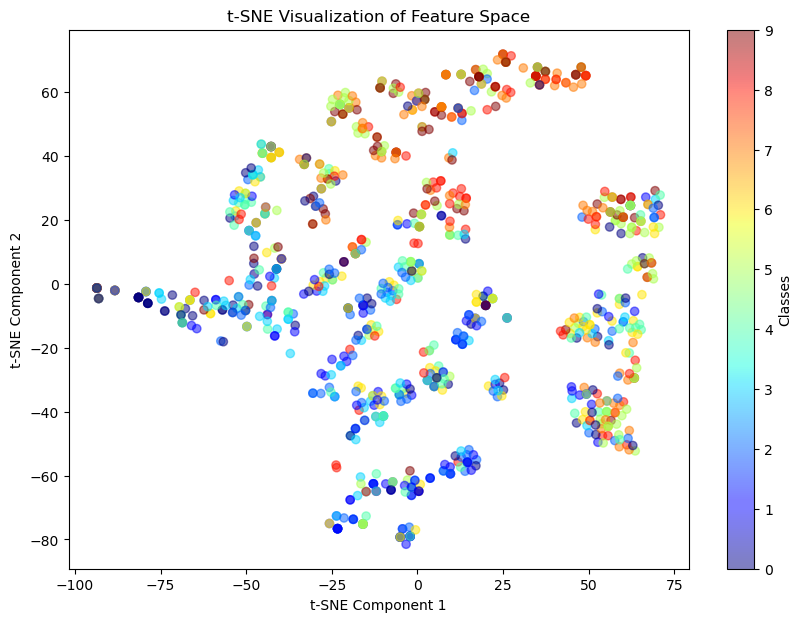

In [13]:
models_glmc = classifier_grid_search(x_train_glcm, y_train_glcm, x_test_glcm, y_test_glcm)
models['models_glmc'] = models_glmc

## ZM


In [14]:
# Measure time for ZM feature extraction
start = time.time()
x_train_zm, y_train_zm = get_fix_feature(image_path_train, 'zm')
x_test_zm, y_test_zm = get_fix_feature(image_path_test, 'zm')
end = time.time()
print(f"Zernike moments feature extraction time: {end - start:.2f} seconds")
logging.info(f"Zernike moments feature extraction time: {end - start:.2f} seconds")

Zernike moments feature extraction time: 136.47 seconds


Training SVM...
SVM - Training time: 482.1477 seconds
SVM - Inference time: 23.7108 seconds
SVM - Average inference time per sample: 0.002371 seconds
SVM - Accuracy: 69.72%
SVM - Confusion Matrix:
[[673  17  35  77  20  43  51   8  69   7]
 [  3 889   8  71   1  12   1   0  12   3]
 [ 21   1 552   9 187  35 136   2  57   0]
 [ 52  48  11 780  37  12  24   0  29   7]
 [ 16   1 171  56 605  16  84   0  51   0]
 [ 48   3  26   4  13 729  25  76  33  43]
 [171  13 173  45 126  37 332   3  93   7]
 [  1   1   0   3   0  25   0 875   9  86]
 [ 66   6  91  50  26  54  47  14 639   7]
 [  9   1   1   9   3  25   0  50   4 898]]
SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.67      0.65      1000
           1       0.91      0.89      0.90      1000
           2       0.52      0.55      0.53      1000
           3       0.71      0.78      0.74      1000
           4       0.59      0.60      0.60      1000
           5      

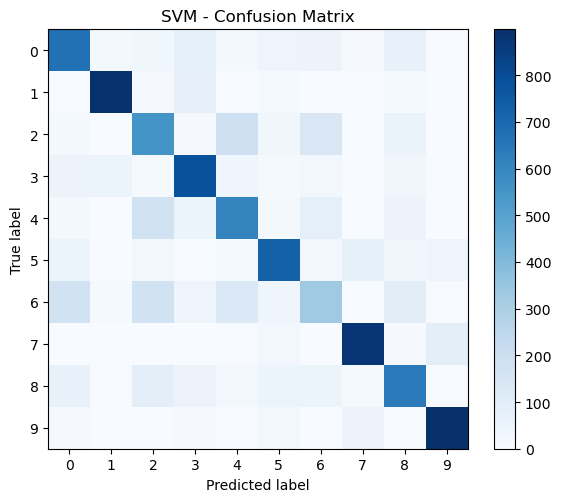

Training Naive Bayes...
Naive Bayes - Training time: 0.4559 seconds
Naive Bayes - Inference time: 0.0442 seconds
Naive Bayes - Average inference time per sample: 0.000004 seconds
Naive Bayes - Accuracy: 60.69%
Naive Bayes - Confusion Matrix:
[[574  24  40  76  39  80  57   4  89  17]
 [  7 868   7  53   3  38   9   0  14   1]
 [ 36   2 415  10 270  59 110   4  88   6]
 [ 43 119   4 660  35  20  44   0  61  14]
 [ 28   7 190  80 535  14  53   1  88   4]
 [ 42   0  30  16  16 625  47 135  27  62]
 [156  15 147  47 243  59 222   0 103   8]
 [  1   3   0  30   1  12   0 725  21 207]
 [ 73  17  68  81  23  67  62  14 586   9]
 [ 14   1   1  26   0  66   0  22  11 859]]
Naive Bayes - Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.57      0.58      1000
           1       0.82      0.87      0.84      1000
           2       0.46      0.41      0.44      1000
           3       0.61      0.66      0.63      1000
           4       

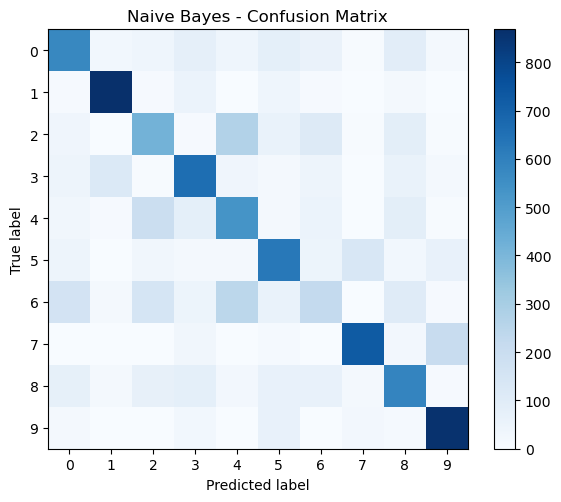

Training Random Forest...
Random Forest - Training time: 1197.8513 seconds
Random Forest - Inference time: 0.9370 seconds
Random Forest - Average inference time per sample: 0.000094 seconds
Random Forest - Accuracy: 76.78%
Random Forest - Confusion Matrix:
[[724   4  29  49  11  37  71   0  64  11]
 [  4 923   6  38   3   6   4   0  12   4]
 [ 18   0 672   8 145  21  82   1  50   3]
 [ 29  14   7 838  34   9  26   0  35   8]
 [ 13   0 163  36 659   7  74   0  47   1]
 [ 10   1   7   4   4 871   3  49  15  36]
 [161   4 171  33 103  23 424   1  78   2]
 [  0   0   0   5   0  16   0 913   1  65]
 [ 48   4  88  38  10  43  35   6 724   4]
 [  3   0   1   6   0  22   0  34   4 930]]
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1000
           1       0.97      0.92      0.95      1000
           2       0.59      0.67      0.63      1000
           3       0.79      0.84      0.82      1000
  

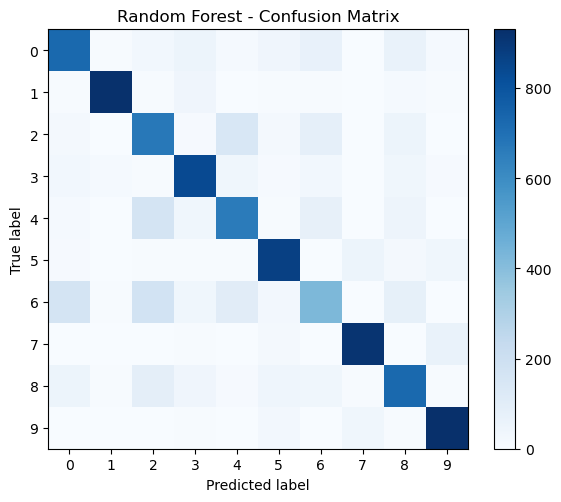

Training KNN...
KNN - Training time: 23.5543 seconds
KNN - Inference time: 1.3879 seconds
KNN - Average inference time per sample: 0.000139 seconds
KNN - Accuracy: 76.91%
KNN - Confusion Matrix:
[[724  11  30  28  16  25  99   4  49  14]
 [  6 945   4  27   4   2   2   1   6   3]
 [ 23   2 681   8 130  16  99   3  31   7]
 [ 35  29  10 814  37  10  27   2  26  10]
 [ 12   0 205  35 630   9  81   2  25   1]
 [ 12   2   6   2   2 836   1  69   7  63]
 [156   5 151  30 107  18 457   2  65   9]
 [  0   0   0   2   0  11   0 949   1  37]
 [ 43   9  64  23  29  41  47  16 716  12]
 [  1   1   1   3   0   9   0  42   4 939]]
KNN - Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1000
           1       0.94      0.94      0.94      1000
           2       0.59      0.68      0.63      1000
           3       0.84      0.81      0.83      1000
           4       0.66      0.63      0.64      1000
           5       0

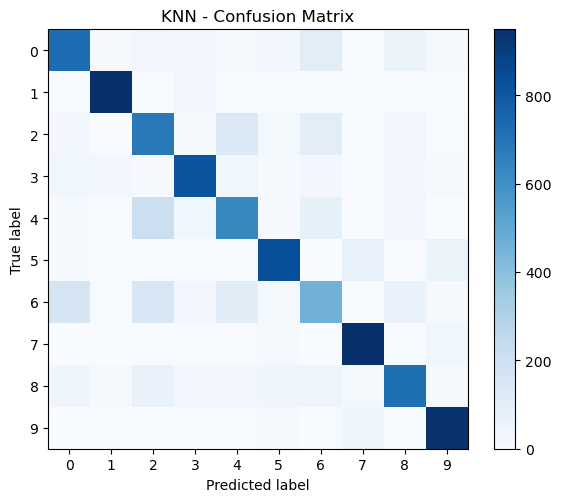

Performing t-SNE...


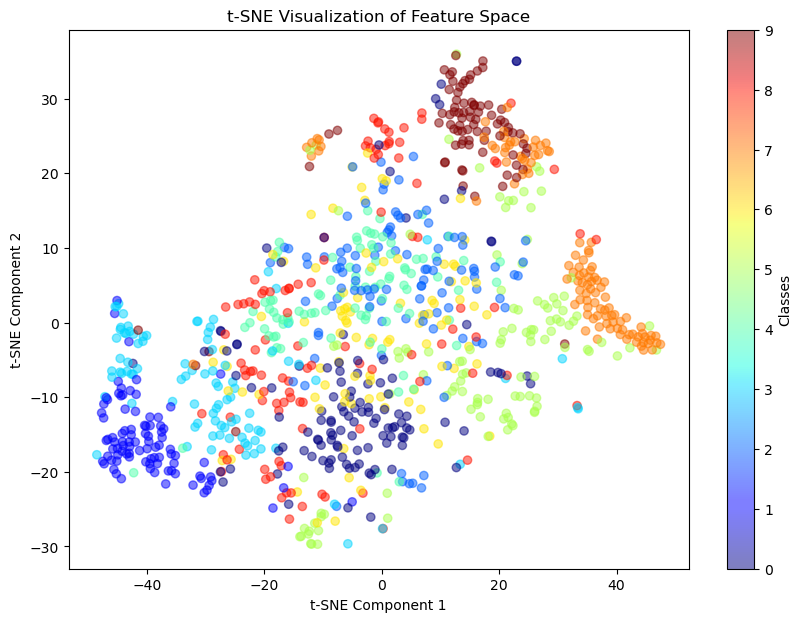

In [15]:
models_zm = classifier_grid_search(x_train_zm, y_train_zm, x_test_zm, y_test_zm)

## HOG + LBP


In [16]:
# Measure time for feature combination
start = time.time()
x_combined_train_hog_lbp = feature_combiner(x_train_hog, x_train_lbp)
x_combined_test_hog_lbp = feature_combiner(x_test_hog, x_test_lbp)
y_combined_train_hog_lbp = y_train_hog  # Assuming labels remain the same
y_combined_test_hog_lbp = y_test_hog
end = time.time()
print(f"Combined (HOG + LBP) feature extraction time: {end - start:.2f} seconds")
logging.info(f"Combined (HOG + LBP) feature extraction time: {end - start:.2f} seconds")

Combined (HOG + LBP) feature extraction time: 0.43 seconds


Training SVM...
SVM - Training time: 807.7567 seconds
SVM - Inference time: 103.5910 seconds
SVM - Average inference time per sample: 0.010359 seconds
SVM - Accuracy: 86.55%
SVM - Confusion Matrix:
[[841   3  14  26   7   0  99   0  10   0]
 [  0 955   2  27  10   0   5   0   1   0]
 [ 21   0 790  10  88   0  88   0   3   0]
 [ 27  11   6 876  35   0  43   0   2   0]
 [  1   1  84  45 771   0  93   0   5   0]
 [  0   0   0   0   0 945   0  40   1  14]
 [151   1  82  45  91   0 618   0  12   0]
 [  0   0   0   0   0  22   0 953   1  24]
 [  3   2   5   2   6   6  12   1 963   0]
 [  0   0   0   0   0  10   1  45   1 943]]
SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1000
           1       0.98      0.95      0.97      1000
           2       0.80      0.79      0.80      1000
           3       0.85      0.88      0.86      1000
           4       0.76      0.77      0.77      1000
           5     

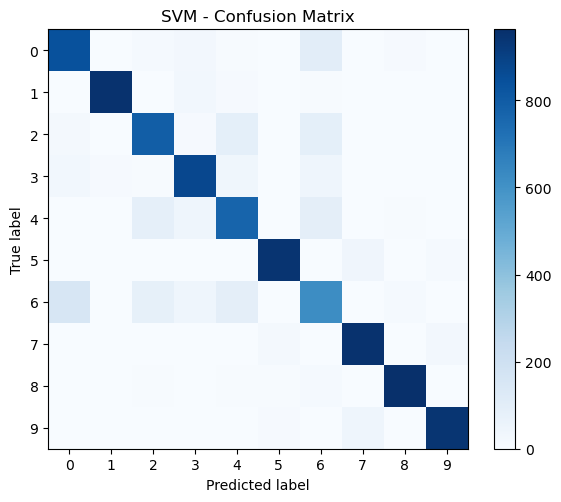

Training Naive Bayes...
Naive Bayes - Training time: 3.2009 seconds
Naive Bayes - Inference time: 0.6722 seconds
Naive Bayes - Average inference time per sample: 0.000067 seconds
Naive Bayes - Accuracy: 60.72%
Naive Bayes - Confusion Matrix:
[[685   4  16 156  84   0  34   0  21   0]
 [  0 887   4  84  17   0   6   0   2   0]
 [  9   0 236  53 600   0  82   0  20   0]
 [  5 173   7 724  71   0  15   0   5   0]
 [  0   2  51 137 763   0  33   0  14   0]
 [  0   0   0   0   0 141   7 561  23 268]
 [175   3  62 142 465   0 111   0  42   0]
 [  0   0   0   0   0   8   0 962   5  25]
 [  1   1   7  64  99   1  20   5 794   8]
 [  0   0   2   3   2   2   1 215   6 769]]
Naive Bayes - Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.69      0.73      1000
           1       0.83      0.89      0.86      1000
           2       0.61      0.24      0.34      1000
           3       0.53      0.72      0.61      1000
           4       

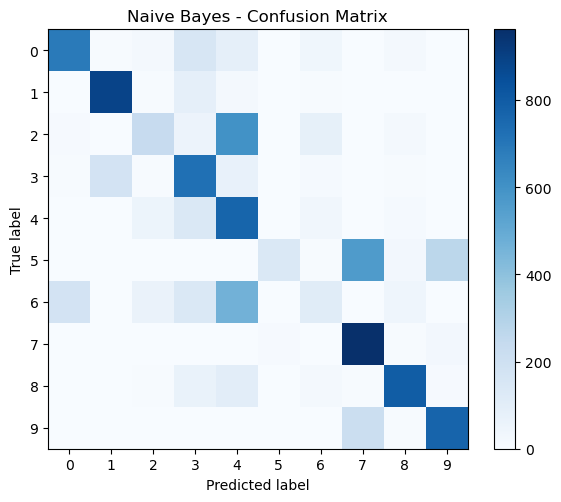

Training Random Forest...
Random Forest - Training time: 5268.7803 seconds
Random Forest - Inference time: 1.3239 seconds
Random Forest - Average inference time per sample: 0.000132 seconds
Random Forest - Accuracy: 84.30%
Random Forest - Confusion Matrix:
[[827   3  25  49  10   0  71   0  15   0]
 [  1 933   5  29  11   0  19   0   2   0]
 [  9   0 790  13  88   0  92   0   8   0]
 [ 15   9   5 861  42   0  65   0   3   0]
 [  0   0 114  54 740   0  87   0   5   0]
 [  0   0   0   0   0 907   1  55   6  31]
 [191   0  89  54 107   0 534   0  25   0]
 [  0   0   0   0   0  21   0 932   4  43]
 [  1   1  10   7   7   4  12   4 953   1]
 [  0   0   0   2   0   3   0  40   2 953]]
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1000
           1       0.99      0.93      0.96      1000
           2       0.76      0.79      0.78      1000
           3       0.81      0.86      0.83      1000
  

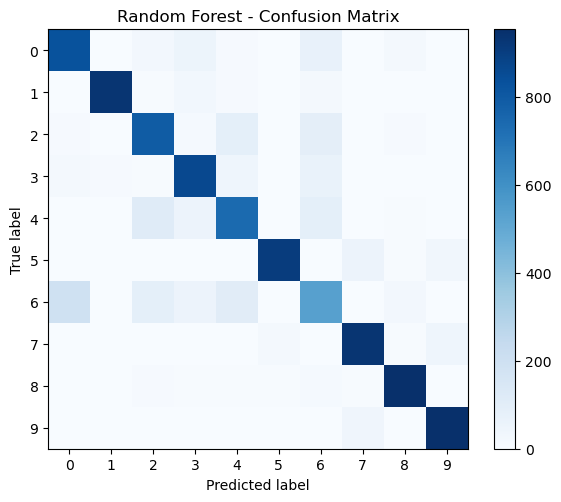

Training KNN...
KNN - Training time: 114.2819 seconds
KNN - Inference time: 7.9621 seconds
KNN - Average inference time per sample: 0.000796 seconds
KNN - Accuracy: 84.96%
KNN - Confusion Matrix:
[[855  10  18  24   8   1  73   0  10   1]
 [  0 975   3  10   7   0   2   0   3   0]
 [ 29   1 779  14 103   0  71   0   3   0]
 [ 25  59  14 835  42   0  25   0   0   0]
 [  3   5 107  43 760   0  81   0   1   0]
 [  0   0   0   0   0 891   0  76   2  31]
 [195  15 109  35 104   0 525   0  17   0]
 [  0   0   0   0   0   6   0 959   0  35]
 [  9   3   5   2   5   6  12   2 953   3]
 [  0   0   0   0   0   0   1  35   0 964]]
KNN - Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.85      0.81      1000
           1       0.91      0.97      0.94      1000
           2       0.75      0.78      0.77      1000
           3       0.87      0.83      0.85      1000
           4       0.74      0.76      0.75      1000
           5       

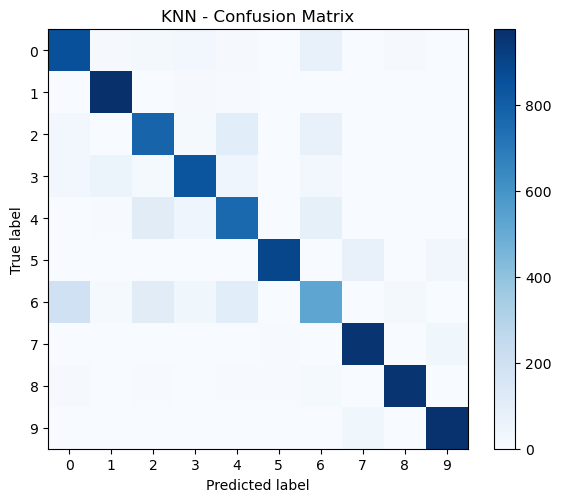

Performing t-SNE...


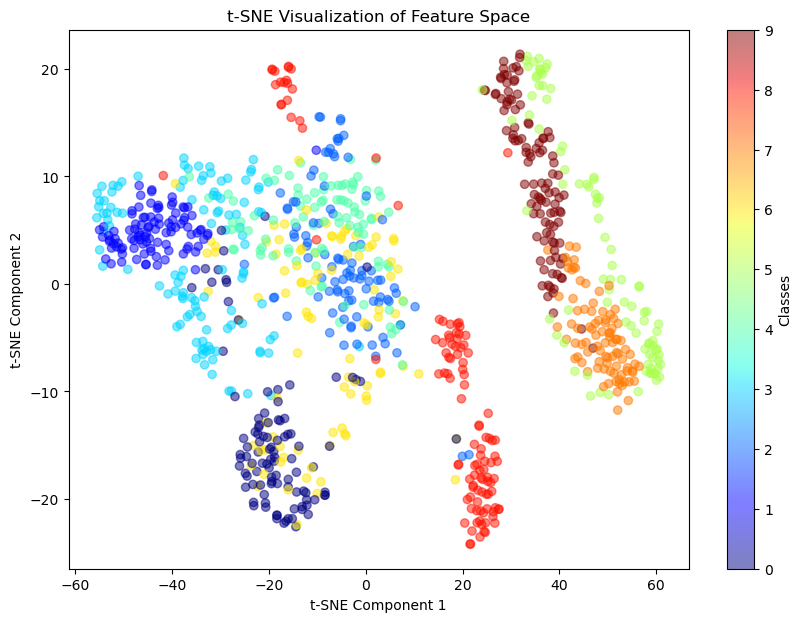

In [17]:
models_hog_lbp = classifier_grid_search(x_combined_train_hog_lbp, y_combined_train_hog_lbp, x_combined_test_hog_lbp, y_combined_test_hog_lbp)
models['models_hog_lbp'] = models_hog_lbp

## HOG + GLCM


In [18]:
# Measure time for feature combination
start = time.time()
x_combined_train_hog_glcm = feature_combiner(x_train_hog, x_train_glcm)
x_combined_test_hog_glcm = feature_combiner(x_test_hog, x_test_glcm)
y_combined_train_hog_glcm = y_train_hog  # Assuming labels remain the same
y_combined_test_hog_glcm = y_test_hog
end = time.time()
print(f"Combined (HOG + GLCM) feature extraction time: {end - start:.2f} seconds")
logging.info(f"Combined (HOG + GLCM) feature extraction time: {end - start:.2f} seconds")

Combined (HOG + GLCM) feature extraction time: 0.47 seconds


Training SVM...
SVM - Training time: 864.7304 seconds
SVM - Inference time: 110.2809 seconds
SVM - Average inference time per sample: 0.011028 seconds
SVM - Accuracy: 86.27%
SVM - Confusion Matrix:
[[835   2  14  24   4   0 111   0  10   0]
 [  1 961   1  22   8   0   6   0   1   0]
 [ 20   0 779   9  90   0  98   0   4   0]
 [ 24  13   7 884  28   0  43   0   1   0]
 [  0   0  97  47 758   0  95   0   3   0]
 [  0   0   0   0   0 943   0  44   1  12]
 [151   2  84  42  91   0 615   0  15   0]
 [  0   0   0   0   0  21   0 952   1  26]
 [  1   1   5   3   6   6  16   2 960   0]
 [  0   0   0   0   0   9   1  49   1 940]]
SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1000
           1       0.98      0.96      0.97      1000
           2       0.79      0.78      0.78      1000
           3       0.86      0.88      0.87      1000
           4       0.77      0.76      0.76      1000
           5     

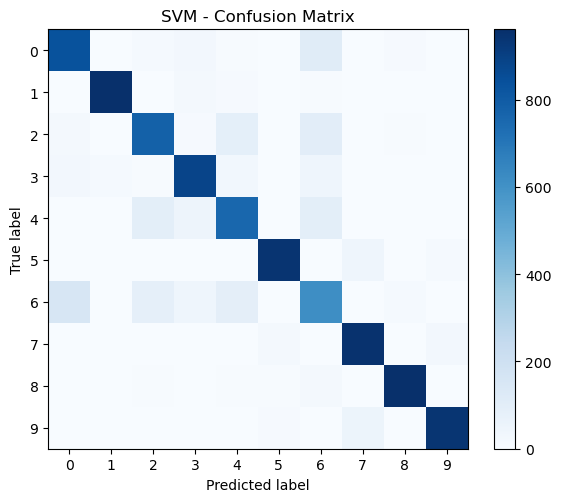

Training Naive Bayes...
Naive Bayes - Training time: 3.4248 seconds
Naive Bayes - Inference time: 0.6920 seconds
Naive Bayes - Average inference time per sample: 0.000069 seconds
Naive Bayes - Accuracy: 60.43%
Naive Bayes - Confusion Matrix:
[[693   5  17 149  83   0  34   0  19   0]
 [  2 896   3  75  16   0   6   0   2   0]
 [  9   0 227  53 606   0  81   0  24   0]
 [  9 182   8 713  66   0  17   0   5   0]
 [  0   2  50 139 762   0  31   0  16   0]
 [  0   0   0   0   0 148   7 579  22 244]
 [183   3  56 135 449   0 127   0  47   0]
 [  0   0   0   0   0  16   0 960   4  20]
 [  1   1  10  64  96   1  25   7 790   5]
 [  0   0   1   3   2   7   2 253   5 727]]
Naive Bayes - Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.69      0.73      1000
           1       0.82      0.90      0.86      1000
           2       0.61      0.23      0.33      1000
           3       0.54      0.71      0.61      1000
           4       

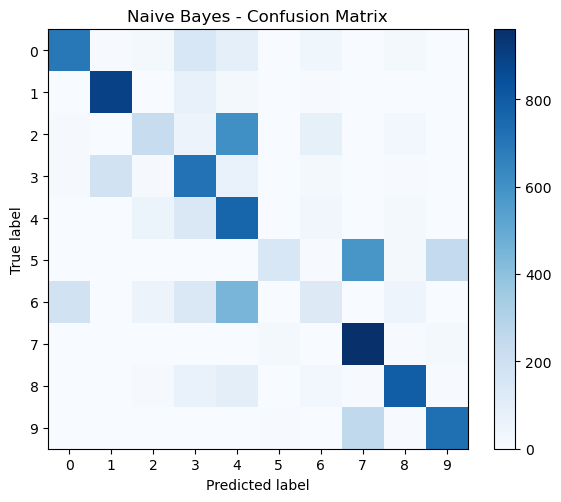

Training Random Forest...
Random Forest - Training time: 5205.2338 seconds
Random Forest - Inference time: 1.3553 seconds
Random Forest - Average inference time per sample: 0.000136 seconds
Random Forest - Accuracy: 83.73%
Random Forest - Confusion Matrix:
[[821   2  13  58  11   1  81   0  13   0]
 [  1 927   6  33  14   0  16   0   3   0]
 [  8   0 776  10  91   0 106   0   9   0]
 [ 17   8   1 869  40   0  63   0   2   0]
 [  0   0 116  59 725   0  92   0   8   0]
 [  0   0   0   0   0 899   1  53  11  36]
 [199   1  94  45 117   0 521   0  23   0]
 [  0   0   0   0   0  12   0 937   3  48]
 [  1   0   7  10   8   4  17   4 949   0]
 [  0   0   0   2   0   5   1  42   1 949]]
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1000
           1       0.99      0.93      0.96      1000
           2       0.77      0.78      0.77      1000
           3       0.80      0.87      0.83      1000
  

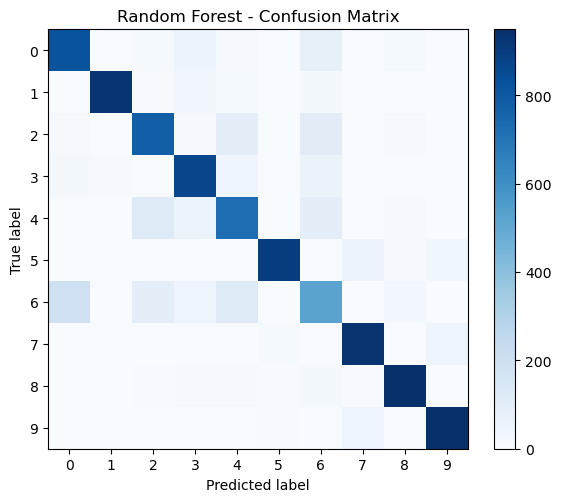

Training KNN...
KNN - Training time: 99.9501 seconds
KNN - Inference time: 8.2571 seconds
KNN - Average inference time per sample: 0.000826 seconds
KNN - Accuracy: 83.14%
KNN - Confusion Matrix:
[[837  13  17  28   9   2  84   0  10   0]
 [  2 972   3  12   5   0   5   0   1   0]
 [ 35   1 764  10 107   0  79   0   4   0]
 [ 28  88  13 802  33   0  34   0   2   0]
 [  2   5 120  49 727   0  96   0   1   0]
 [  0   0   0   0   0 862   0  94   3  41]
 [202  18 110  40 107   0 499   0  24   0]
 [  0   0   0   0   0   6   0 958   0  36]
 [ 10   2   3   4   4  10  13   6 945   3]
 [  0   0   0   0   0   3   1  48   0 948]]
KNN - Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.84      0.79      1000
           1       0.88      0.97      0.93      1000
           2       0.74      0.76      0.75      1000
           3       0.85      0.80      0.82      1000
           4       0.73      0.73      0.73      1000
           5       0

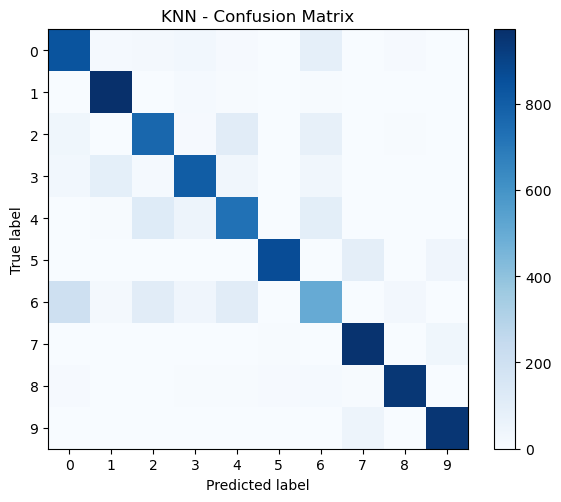

Performing t-SNE...


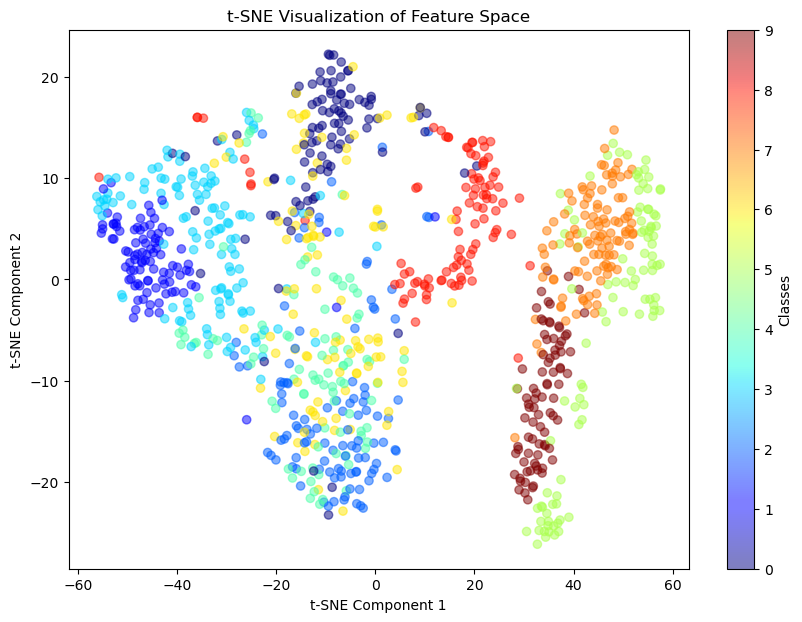

In [19]:
models_hog_glcm = classifier_grid_search(x_combined_train_hog_glcm, y_combined_train_hog_glcm, x_combined_test_hog_glcm, y_combined_test_hog_glcm)
models['models_hog_glcm'] = models_hog_glcm

## SIFT


In [21]:

# Measure time for SIFT feature extraction
start = time.time()
x_train_sift, y_train_sift = get_SIFT_feature(image_path_train)
x_test_sift, y_test_sift = get_SIFT_feature(image_path_test)
end = time.time()
print(f"SIFT feature extraction time: {end - start:.2f} seconds")
logging.info(f"SIFT feature extraction time: {end - start:.2f} seconds")


SIFT feature extraction time: 329.85 seconds


Training SVM...
SVM - Training time: 3421.2331 seconds
SVM - Inference time: 101.6096 seconds
SVM - Average inference time per sample: 0.010161 seconds
SVM - Accuracy: 13.61%
SVM - Confusion Matrix:
[[ 82  39 131 154 150 106 137  29 141  31]
 [ 15   2  11 766  67  13  26   7  72  21]
 [165  24  65 225 123  81  92  18 124  83]
 [ 82   5  48 510 101  41  62  39  91  21]
 [133  30  80 239 127 106  82  24 120  59]
 [132  20 105 194  95 125 138  15  99  77]
 [118  32  94 224 132  83  88  18 141  70]
 [229   9  22 380  37  31  74  47 119  52]
 [ 71  35  71 237 125 108  92  24 199  38]
 [234  17  67 150  97  34 168  27  90 116]]
SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.07      0.08      0.07      1000
           1       0.01      0.00      0.00      1000
           2       0.09      0.07      0.08      1000
           3       0.17      0.51      0.25      1000
           4       0.12      0.13      0.12      1000
           5    

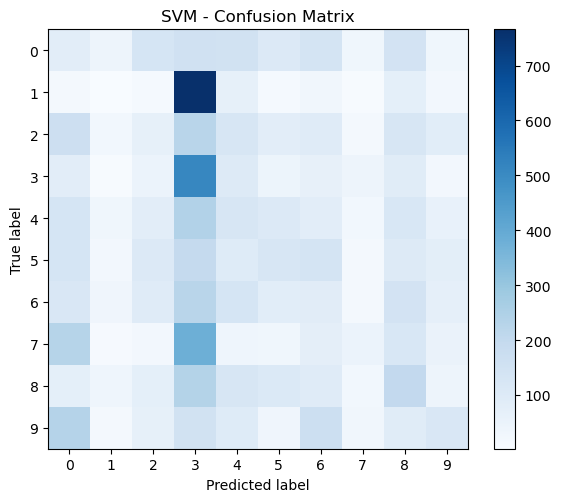

Training Naive Bayes...
Naive Bayes - Training time: 1.9662 seconds
Naive Bayes - Inference time: 0.2260 seconds
Naive Bayes - Average inference time per sample: 0.000023 seconds
Naive Bayes - Accuracy: 14.06%
Naive Bayes - Confusion Matrix:
[[134   0  23 185 260   8 147   0 243   0]
 [ 38   0   2 862  52   6  19   0  21   0]
 [192   0  52 217 225  18 101   0 195   0]
 [ 63   0   9 592 162   7  51   0 116   0]
 [153   0  43 242 226  24 105   0 207   0]
 [183   0  77 232 149  13 167   0 179   0]
 [178   0  33 215 261  12 109   0 192   0]
 [ 94   0   1 626  85   0  19   0 175   0]
 [104   0  22 234 206  14 140   0 280   0]
 [199   0   9 283 178   3  98   0 230   0]]
Naive Bayes - Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.13      0.11      1000
           1       0.00      0.00      0.00      1000
           2       0.19      0.05      0.08      1000
           3       0.16      0.59      0.25      1000
           4       

D:\software\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\software\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\software\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


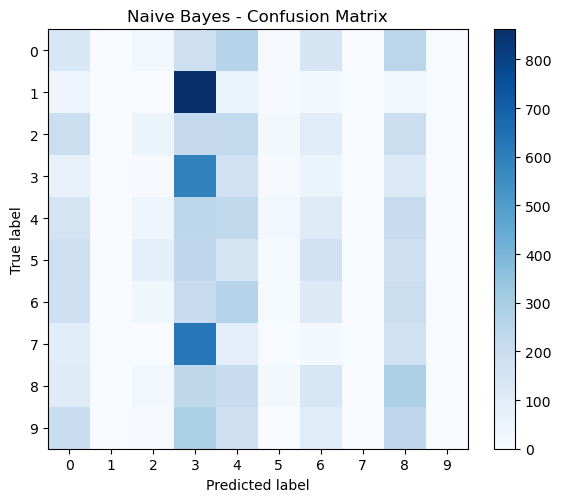

Training Random Forest...
Random Forest - Training time: 250.2836 seconds
Random Forest - Inference time: 0.7817 seconds
Random Forest - Average inference time per sample: 0.000078 seconds
Random Forest - Accuracy: 12.57%
Random Forest - Confusion Matrix:
[[ 94  61 195  13  33  97  18  92 373  24]
 [ 35  11   1   1   6  63  24   9 821  29]
 [120  22  31  19  33 135   5  54 511  70]
 [177  22  53  12   7 135   5  84 488  17]
 [128  16  49  20  29 142  12  74 475  55]
 [ 71 101 100  24  41 159  37  53 273 141]
 [122  38  90  14  30 102  11  58 472  63]
 [325   7  45   2   5  96   7  56 317 140]
 [ 90  80  48  22  19 148   3  51 502  37]
 [134  56  96   8   6  70   2  81 195 352]]
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.07      0.09      0.08      1000
           1       0.03      0.01      0.02      1000
           2       0.04      0.03      0.04      1000
           3       0.09      0.01      0.02      1000
   

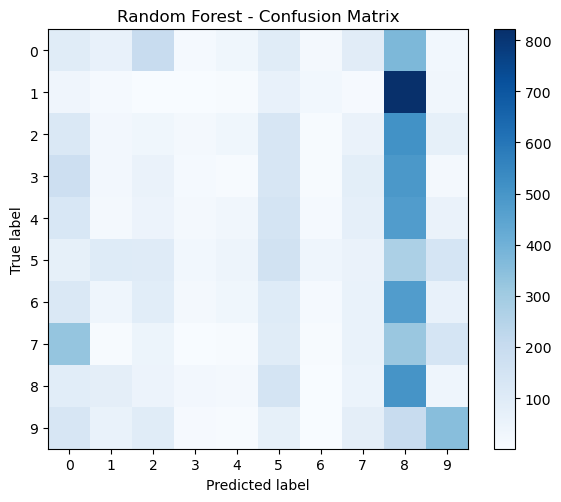

Training KNN...
KNN - Training time: 46.1142 seconds
KNN - Inference time: 3.4631 seconds
KNN - Average inference time per sample: 0.000346 seconds
KNN - Accuracy: 12.90%
KNN - Confusion Matrix:
[[277  99 191  69  76  51  70  53  88  26]
 [314 426  22 100   7   4   8   9  93  17]
 [320  61 112  92 118  34  77  63  68  55]
 [416 138 133 131  39  12  34  48  40   9]
 [340  95 110  80 107  37  55  81  51  44]
 [285  70 162  91 142  58  59  27  57  49]
 [329 103 145  72  95  24  61  47  76  48]
 [540  97  73 101  37   3  22  32  66  29]
 [274 109 114 107  77  45  98  75  70  31]
 [417  80 145  82  89   7  52  69  43  16]]
KNN - Classification Report:
              precision    recall  f1-score   support

           0       0.08      0.28      0.12      1000
           1       0.33      0.43      0.37      1000
           2       0.09      0.11      0.10      1000
           3       0.14      0.13      0.14      1000
           4       0.14      0.11      0.12      1000
           5       0

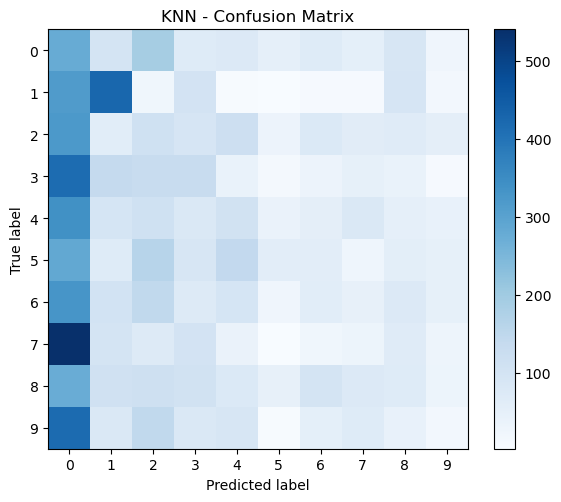

Performing t-SNE...


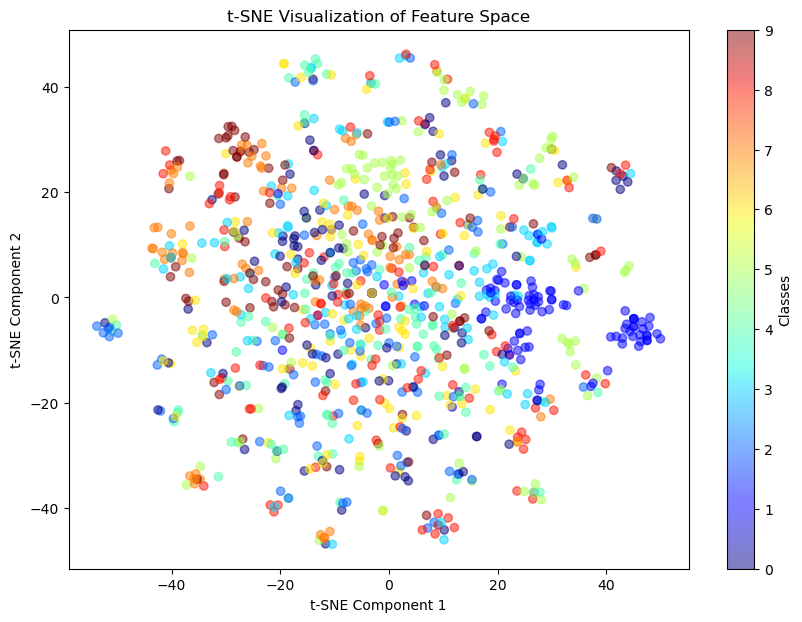

In [22]:
models_sift = classifier_grid_search(x_train_sift, y_train_sift, x_test_sift, y_test_sift)
models['models_sift'] = models_sift

In [23]:
# save models

for name, model in models.items():
    joblib.dump(model, f'{name}.pkl')  
    print(f"Model {name} saved to {name}.pkl")

Model models_hog saved to models_hog.pkl
Model models_lbp saved to models_lbp.pkl
Model models_glmc saved to models_glmc.pkl
Model models_hog_lbp saved to models_hog_lbp.pkl
Model models_hog_glcm saved to models_hog_glcm.pkl
Model models_sift saved to models_sift.pkl


In [24]:
logging.info("*****************This is the end of this traning********************")

In [26]:
feature_dic = {
    'x_train_lbp': x_train_lbp,
    'y_train_lbp': y_train_lbp,
    'x_test_lbp': x_test_lbp,
    'y_test_lbp': y_test_lbp,
    'x_train_hog': x_train_hog,
    'y_train_hog': y_train_hog,
    'x_test_hog': x_test_hog,
    'y_test_hog': y_test_hog,
    'x_train_glcm': x_train_glcm,
    'y_train_glcm': y_train_glcm,
    'x_test_glcm': x_test_glcm,
    'y_test_glcm': y_test_glcm,
    'x_train_zm': x_train_zm,
    'y_train_zm': y_train_zm,
    'x_test_zm': x_test_zm,
    'y_test_zm': y_test_zm,
    'x_combined_train_hog_lbp': x_combined_train_hog_lbp,
    'y_combined_train_hog_lbp': y_combined_train_hog_lbp,
    'x_combined_test_hog_lbp': x_combined_test_hog_lbp,
    'y_combined_test_hog_lbp': y_combined_test_hog_lbp,
    'x_combined_train_hog_glcm': x_combined_train_hog_glcm,
    'y_combined_train_hog_glcm': y_combined_train_hog_glcm,
    'x_combined_test_hog_glcm': x_combined_test_hog_glcm,
    'y_combined_test_hog_glcm': y_combined_test_hog_glcm,
    'x_train_sift': x_train_sift,
    'y_train_sift': y_train_sift,
    'x_test_sift': x_test_sift,
    'y_test_sift': y_test_sift,
    
}

joblib.dump(feature_dic, "features_fmnist-hand.pkl")

print("Features saved successfully with joblib!")


Features saved successfully with joblib!
